


Going to do another make_data() 
But first, take out the scaling part so I can do MinMax instead , later on.



In [1]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

In [3]:
%%time

# I had 
crew1df = pd.read_pickle('data/crew_1-train.pkl')
crew2df = pd.read_pickle('data/crew_2-train.pkl')

df1to2 = pd.concat([crew1df, crew2df])

cols = ['r', 'ecg', 'gsr', 
        'eeg_fp1','eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', ]

ts = mu.quickts()
newdir = f'data/{ts}'
os.mkdir(newdir)
print(f'Writing to {newdir} , just created.')

# with ipdb.launch_ipdb_on_exception():
out = mu.make_data(df1to2, crews={'training': [1],
                    'test': [2]},
              window_size=64,
               row_batch_size=10000,
         feature_cols=cols,
              save_dir=newdir)


Writing to data/2019-12-21T215926Z , just created.
Start building training set 2019-12-21T215926Z
num slices 44
size_remainder,  7652
Start building testing set 2019-12-21T220000Z
num slices 55
size_remainder,  2868
CPU times: user 1min 8s, sys: 8.94 s, total: 1min 17s
Wall time: 1min 18s


In [ ]:
# There is a lot a lot of data, split up into multiple slices, 
# so to do the MinMaxScaler , can I just grab biggest from each, 
# and create a scaler from that and then just transform live later? 
#
# or more generally can you .fit() more than once 
# and what does that imply?

In [5]:
from sklearn.preprocessing import MinMaxScaler
X = np.array([[-1, 2], [-0.5, 6], [0, 10], [1, 18]])
scaler = MinMaxScaler()
print(scaler.fit(X))

print(scaler.data_min_, scaler.data_max_)

print(scaler.transform(X))
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


MinMaxScaler(copy=True, feature_range=(0, 1))
[-1.  2.] [ 1. 18.]
[[0.   0.  ]
 [0.25 0.25]
 [0.5  0.5 ]
 [1.   1.  ]]


In [7]:
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
print(X_std)

[[0.   0.  ]
 [0.25 0.25]
 [0.5  0.5 ]
 [1.   1.  ]]


#### Oh wow partial fit? 
Signature: scaler.partial_fit(X, y=None)
Docstring:
Online computation of min and max on X for later scaling.
All of X is processed as a single batch. This is intended for cases
when `fit` is not feasible due to very large number of `n_samples`
or because X is read from a continuous stream.

```
scaler = MinMaxScaler()
#scaler.set_params
# scaler.partial_fit?
# 
```


In [13]:
# Nice so based on this... partial_fit of parts is equivalent
# looking to a full fit
X = np.array([[-1, 2], [-0.5, 6], [0, 10], [1, 18]])

scaler = MinMaxScaler()
for i in range(4):
    print(f'i: {i}')
    scaler.partial_fit(X[i:i+1,:])

    print(scaler.data_min_, scaler.data_max_)

    print(scaler.transform(X))


i: 0
[-1.  2.] [-1.  2.]
[[ 0.   0. ]
 [ 0.5  4. ]
 [ 1.   8. ]
 [ 2.  16. ]]
i: 1
[-1.  2.] [-0.5  6. ]
[[0. 0.]
 [1. 1.]
 [2. 2.]
 [4. 4.]]
i: 2
[-1.  2.] [ 0. 10.]
[[0.  0. ]
 [0.5 0.5]
 [1.  1. ]
 [2.  2. ]]
i: 3
[-1.  2.] [ 1. 18.]
[[0.   0.  ]
 [0.25 0.25]
 [0.5  0.5 ]
 [1.   1.  ]]


In [49]:
def read_h5_raw(source_location, name):
    with h5py.File(source_location, 'r+') as fd:
        return fd[name].__array__()

def h5_keys(loc):
    with h5py.File(loc, 'r+') as fd:
        return list(fd.keys())


In [61]:
# Ah cool, so indeed zip() is its own inverse.
# a = np.array(params_vec)
# b = np.array(list(zip(*params_vec)))
# print(a)
# print(np.array(list(zip(*b))))

[[662.062012 666.276001]
 [654.408997 676.028015]
 [653.052979 676.028015]
 [653.052979 676.028015]
 [650.200989 676.028015]]
[[662.062012 666.276001]
 [654.408997 676.028015]
 [653.052979 676.028015]
 [653.052979 676.028015]
 [650.200989 676.028015]]


In [68]:
# Next:
# Oh wow that's perfect ! ... So I can use this to first create a 
# Standard scaler, across the whole dataset i have. perfect.

def build_scaler_from_h5(loc, datasets, feature):
    # one label at a time here..
    scaler = MinMaxScaler()
    params_vec = []
    for name in tqdm(datasets):
        X = read_h5_raw(loc, name)
        fullsize = X.shape[0]*X.shape[1]
        scaler.partial_fit(
            np.reshape(X[:, :, feature].ravel(),
                       (fullsize, 1)))
        params_vec.append(
            [scaler.data_min_[0], scaler.data_max_[0]])

    return scaler, params_vec

In [28]:
trainloc = 'data/2019-12-21T215926Z/train.h5'

first = [x for x in h5_keys(trainloc) 
                               if '_X' in x][0]
X = read_h5_raw(trainloc, first)
scaler = MinMaxScaler()
scaler.partial_fit(np.reshape(X[:, :, 0].ravel(), (635904, 1)))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [66]:
%%time
trainloc = 'data/2019-12-21T215926Z/train.h5'
#X = read_h5_raw(f'data/2019-12-21T215926Z/train.h5', )
scaler, params_vec = build_scaler_from_h5(
                     trainloc,
                     datasets=[x for x in h5_keys(trainloc) 
                               if '_X' in x],
                     label=0
                     )


100%|██████████| 45/45 [00:11<00:00,  4.00it/s]

CPU times: user 426 ms, sys: 609 ms, total: 1.04 s
Wall time: 11.3 s


Text(0.5, 1.0, 'min/max for label=0')

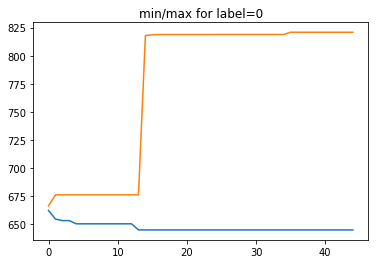

In [67]:
#b = np.array(list(zip(*params_vec)))
plt.plot(params_vec)
plt.title(f'min/max for label={0}')

In [ ]:
# mysterious jump we have there huh.

In [71]:
%%time
trainloc = 'data/2019-12-21T215926Z/train.h5'
#X = read_h5_raw(f'data/2019-12-21T215926Z/train.h5', )
outvec = [
    build_scaler_from_h5(
                     trainloc,
                     datasets=[x for x in h5_keys(trainloc) 
                               if '_X' in x],
                     feature=i)
    for i in range(8)]
scalers = {i: outvec[i][0] for i in range(8)}

100%|██████████| 45/45 [00:00<00:00, 59.29it/s]

CPU times: user 2.7 s, sys: 3.38 s, total: 6.08 s
Wall time: 6.1 s


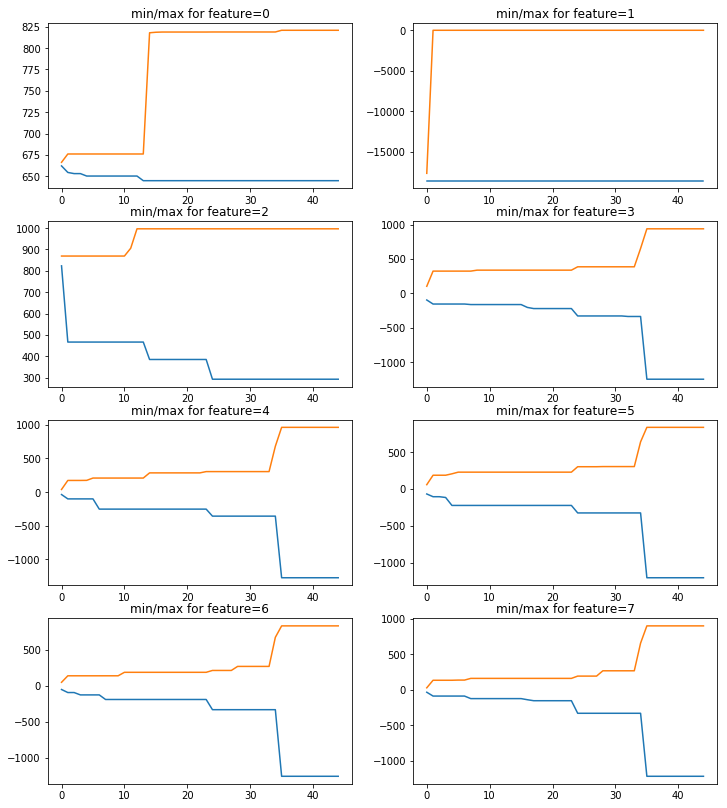

In [72]:
fig = plt.figure(figsize=(12, 14))
for i in range(8):
    params_vec = outvec[i][1]
    ax = fig.add_subplot(int('42' + str(i+1)))
    ax.plot(params_vec)
    ax.set(title=(f'min/max for feature={i}'))


# fig = plt.figure(figsize=(12,14))
# for i in range(8):
#     ax = fig.add_subplot(int('42' + str(i+1)))
#     ax.hist(X[:,0,i], bins=50)
#     ax.set(title=f'feature {i} hist')
    

In [ ]:
# Ok cool. Glad I also ended up doing this on the pre-scaled data. 
# So next I'll be able to look at the same roughly for the post scaled.

In [82]:
trainloc = 'data/2019-12-21T215926Z/train.h5'
first = [x for x in h5_keys(trainloc) 
                               if '_X' in x][0]
feature = 0
X = read_h5_raw(f'data/2019-12-21T215926Z/train.h5', first)
fullsize = X.shape[0]*X.shape[1]
b = np.reshape(X[:, :, feature].ravel(),
                       (fullsize, 1))
c = np.histogram(b)

In [85]:
print(c[0], c[1])
print(b.shape)

[ 12672  44928  56694  63339  56898  50170  51687  62888 108628 128000] [662.062012  662.4834109 662.9048098 663.3262087 663.7476076 664.1690065
 664.5904054 665.0118043 665.4332032 665.8546021 666.276001 ]
(635904, 1)


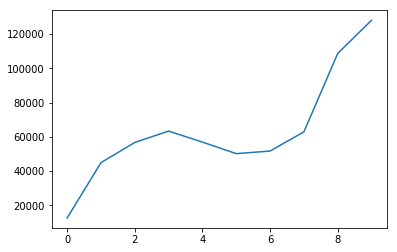

In [84]:
plt.plot(c[0])

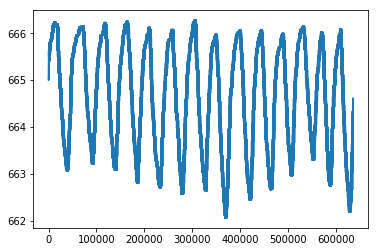

In [86]:
plt.plot(b)

In [89]:
vars(scalers[0])

{'feature_range': (0, 1),
 'copy': True,
 'n_samples_seen_': 28444928,
 'scale_': array([0.00567749]),
 'min_': array([-3.66065535]),
 'data_min_': array([644.765991]),
 'data_max_': array([820.900024]),
 'data_range_': array([176.134033])}

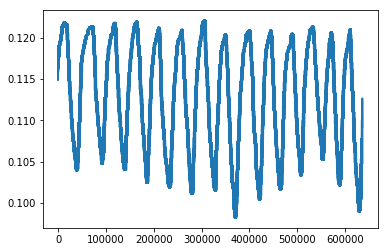

In [90]:
# After scaler..
plt.plot(scalers[0].transform(b))

In [91]:
X = np.array([[-1, 2, 4], [-0.5, 6, 2], [0, 10, 3], [1, 18, 2]])
scaler = MinMaxScaler()
print(scaler.fit(X))

print(scaler.data_min_, scaler.data_max_)

print(scaler.transform(X))
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))




MinMaxScaler(copy=True, feature_range=(0, 1))
[-1.  2.  2.] [ 1. 18.  4.]
[[0.   0.   1.  ]
 [0.25 0.25 0.  ]
 [0.5  0.5  0.5 ]
 [1.   1.   0.  ]]


In [93]:
(X[:,2] - 2)/2

array([1. , 0. , 0.5, 0. ])

#### Multi scaler instead
So I don't have to cut up/ stitch back together 

In [100]:
# print(first)
X = read_h5_raw(f'data/2019-12-21T215926Z/train.h5', first)
print(X.shape)
print(np.reshape(X[:10, :, :], (10*X.shape[1], 8)).shape)
ten = 10
scaler = MinMaxScaler()
scaler.fit(np.reshape(X[:10, :, :], (10*X.shape[1], 8)))
print(scaler.transform(np.reshape(X[:10, :, :], (10*X.shape[1], 8))))

(9936, 64, 8)
(640, 8)
[[0.         0.46141588 0.         ... 0.76985984 0.44254933 0.52833478]
 [0.         0.46141588 0.         ... 0.69486598 0.31096341 0.69697528]
 [0.         0.46141588 0.         ... 0.32758439 0.6828147  0.75729886]
 ...
 [1.         1.         1.         ... 0.48684134 0.42603425 0.38297394]
 [1.         1.         1.         ... 0.77061457 0.93265624 0.57005549]
 [1.         1.         1.         ... 0.70745753 0.80937469 0.30836016]]


In [107]:
# Ok cool... so this reshape seems to be doing what I need..
# It is conserving the dimensionality somehow the way I want it.
Xa = np.vectorize(int)(X[:3,:4,3:5])
print(Xa.shape)
print(Xa)
print(np.reshape(Xa, (12,2)))

(3, 4, 2)
[[[1 8]
  [1 7]
  [1 1]
  [3 0]]

 [[1 7]
  [1 1]
  [3 0]
  [0 0]]

 [[1 1]
  [3 0]
  [0 0]
  [4 4]]]
[[1 8]
 [1 7]
 [1 1]
 [3 0]
 [1 7]
 [1 1]
 [3 0]
 [0 0]
 [1 1]
 [3 0]
 [0 0]
 [4 4]]


In [117]:
# Next:
# Oh wow that's perfect ! ... So I can use this to first create a 
# Standard scaler, across the whole dataset i have. perfect.

def build_many_scalers_from_h5(loc, datasets):
    # one label at a time here..
    scaler = MinMaxScaler()
    params_vec = []
    for name in tqdm(datasets):
        X = read_h5_raw(loc, name)
        fullsize = X.shape[0]*X.shape[1]
        scaler.partial_fit(
            np.reshape(X,
                       (fullsize, X.shape[2])))
        params_vec.append(
            [scaler.data_min_, scaler.data_max_])

    return scaler, params_vec

def apply_scalers(source_loc, datasets):
    # Apply using a suffix, '_scaled'
    pass
    # for each dataset, read. then write '_scaled'

In [118]:
# trainloc = 'data/2019-12-21T215926Z/train.h5'
output = build_many_scalers_from_h5(
                        trainloc, 
                        datasets=[x for x in h5_keys(trainloc) 
                               if '_X' in x]
)


100%|██████████| 45/45 [00:03<00:00, 11.31it/s]


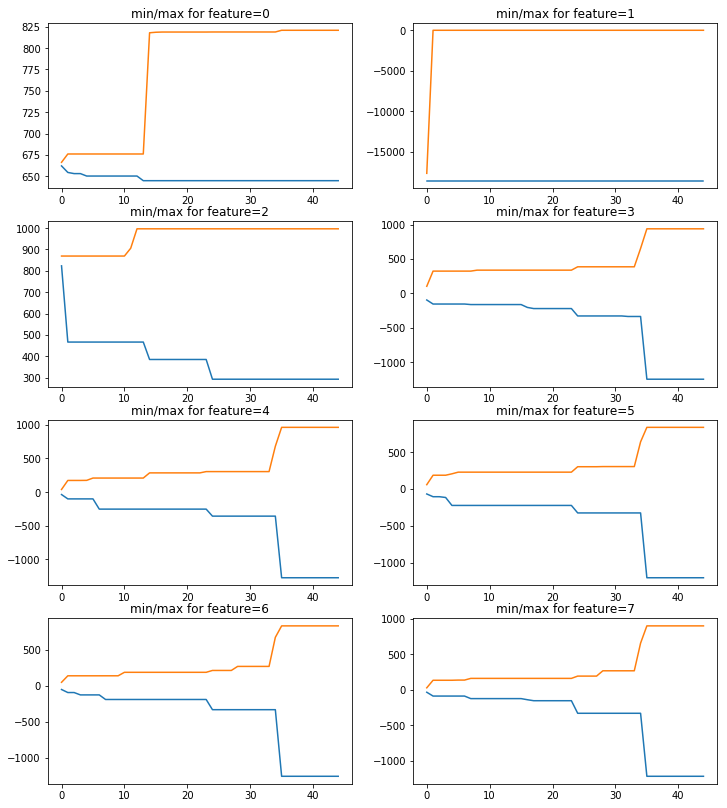

In [128]:
# Ok for the below, looks like this other scaling 
# is working the same way cool..
themin, themax = 0, 1

fig = plt.figure(figsize=(12, 14))
#for i in range(8):


for col in range(8):
    #params_vec = outvec[i][1]
    ax = fig.add_subplot(int('42' + str(col+1)))
    #ax.plot(params_vec)
    ax.set(title=(f'min/max for feature={col}'))

    ax.plot(
        [output[1][i][themin][col] for i in range(len(output[1]))]
    
    )
    ax.plot(
    [output[1][i][themax][col] for i in range(len(output[1]))]
    )

In [130]:
import joblib
output[0]

MinMaxScaler(copy=True, feature_range=(0, 1))

In [132]:
vars(output[0])

{'feature_range': (0, 1),
 'copy': True,
 'n_samples_seen_': 28444928,
 'scale_': array([5.67749448e-03, 5.38048092e-05, 1.41888249e-03, 4.57379548e-04,
        4.47905053e-04, 4.88638892e-04, 4.76582642e-04, 4.71376372e-04]),
 'min_': array([-3.66065535,  1.        , -0.41441583,  0.57033398,  0.56963222,
         0.58968944,  0.6013043 ,  0.57531958]),
 'data_min_': array([   644.765991, -18585.69922 ,    292.071991,  -1246.959961,
         -1271.77002 ,  -1206.800049,  -1261.699951,  -1220.51001 ]),
 'data_max_': array([820.900024,   0.      , 996.85199 , 939.40802 , 960.846008,
        839.700989, 836.572021, 900.937012]),
 'data_range_': array([  176.134033, 18585.69922 ,   704.779999,  2186.367981,
         2232.616028,  2046.501038,  2098.271972,  2121.447022])}

In [135]:
trainloc

'data/2019-12-21T215926Z/train.h5'

In [136]:
ts = mu.quickts()
outdir = f'history/{ts}'
os.mkdir(outdir)
joblib.dump({'scalers': output[0],
        'ts': ts,
        'notebook': 'https://mytensorflow-aviation.notebook.us-east-1.sagemaker.aws/notebooks/aviation-pilot-physiology-hmm/2019-12-21.ipynb',
        'trainloc': trainloc
        
       }, f'{outdir}/scalers.joblib')

['history/2019-12-22T174803Z/scalers.joblib']

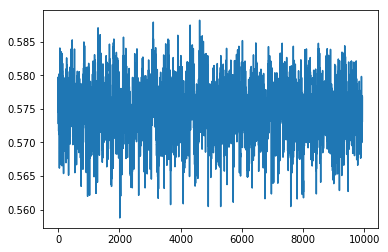

In [172]:
# I had experimented with an Xs, and deleted taht later,
# plt.plot(Xs[:,0,7])

In [173]:
reload(mu)

<module 'mytf.utils' from '/home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py'>

In [180]:
mu.transfer?

In [175]:
def apply_scalers(loc, datasets, scaler, outloc):
    # for each dataset, read. then write '_scaled'
    for name in tqdm(datasets):
        X = read_h5_raw(loc, name)
        original_shape = X.shape
        fullsize = X.shape[0]*X.shape[1]
         
        Xss = np.reshape(scaler.transform(
            np.reshape(X,
                       (fullsize, X.shape[2]))),
                         original_shape)

        mu.save_that(outloc, f'{name}_scaled',
                     Xss)


In [177]:
# Need to apply scaling and also just move the Ylabel data too.
trainloc = 'data/2019-12-21T215926Z/train.h5'
apply_scalers(trainloc, 
                        datasets=[x for x in h5_keys(trainloc) 
                               if '_X' in x][:2],
                   scaler=output[0],
                   outloc=f'{outdir}/train_scaled.h5'

                  )




100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


In [178]:
mu.h5_keys(f'{outdir}/train_scaled.h5')

['dataset_0_X_scaled', 'dataset_10_X_scaled']

In [181]:
%%time
# ok and i deleted that ^^ so I can do it again fully..

trainloc = 'data/2019-12-21T215926Z/train.h5'
apply_scalers(trainloc, 
                   datasets=[x for x in h5_keys(trainloc) 
                               if '_X' in x],
                   scaler=output[0],
                   outloc=f'{outdir}/train_scaled.h5'

                  )
mu.transfer(source_location=trainloc, 
            source_datasets=[x for x in h5_keys(trainloc) 
                               if '_Y' in x], 
            save_location=f'{outdir}/train_scaled.h5')

100%|██████████| 45/45 [00:21<00:00,  2.11it/s]


CPU times: user 1.77 s, sys: 4.09 s, total: 5.86 s
Wall time: 21.7 s


In [183]:
print(mu.h5_keys(f'{outdir}/train_scaled.h5'))

['dataset_0_X_scaled', 'dataset_0_Y', 'dataset_10_X_scaled', 'dataset_10_Y', 'dataset_11_X_scaled', 'dataset_11_Y', 'dataset_12_X_scaled', 'dataset_12_Y', 'dataset_13_X_scaled', 'dataset_13_Y', 'dataset_14_X_scaled', 'dataset_14_Y', 'dataset_15_X_scaled', 'dataset_15_Y', 'dataset_16_X_scaled', 'dataset_16_Y', 'dataset_17_X_scaled', 'dataset_17_Y', 'dataset_18_X_scaled', 'dataset_18_Y', 'dataset_19_X_scaled', 'dataset_19_Y', 'dataset_1_X_scaled', 'dataset_1_Y', 'dataset_20_X_scaled', 'dataset_20_Y', 'dataset_21_X_scaled', 'dataset_21_Y', 'dataset_22_X_scaled', 'dataset_22_Y', 'dataset_23_X_scaled', 'dataset_23_Y', 'dataset_24_X_scaled', 'dataset_24_Y', 'dataset_25_X_scaled', 'dataset_25_Y', 'dataset_26_X_scaled', 'dataset_26_Y', 'dataset_27_X_scaled', 'dataset_27_Y', 'dataset_28_X_scaled', 'dataset_28_Y', 'dataset_29_X_scaled', 'dataset_29_Y', 'dataset_2_X_scaled', 'dataset_2_Y', 'dataset_30_X_scaled', 'dataset_30_Y', 'dataset_31_X_scaled', 'dataset_31_Y', 'dataset_32_X_scaled', 'datase

#### ok now make balanced data again
Following [previous notebook](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-01-batch-train.md)

I had selected `7625` at that point.

In [185]:
# re-evaluate ...
train_scaled_loc = f'{outdir}/train_scaled.h5'
mu.count_data_in_location(loc=train_scaled_loc,
                          datasets=[x for x in h5_keys(train_scaled_loc) 
                               if '_Y' in x])

45it [00:00, 217.04it/s]


{0: 234038, 1: 7625, 2: 179699, 3: 23090}

In [187]:
list(zip([x for x in mu.h5_keys(train_scaled_loc) 
                               if '_X' in x],
[x for x in mu.h5_keys(train_scaled_loc) 
                               if '_Y' in x]))[:5]

[('dataset_0_X_scaled', 'dataset_0_Y'),
 ('dataset_10_X_scaled', 'dataset_10_Y'),
 ('dataset_11_X_scaled', 'dataset_11_Y'),
 ('dataset_12_X_scaled', 'dataset_12_Y'),
 ('dataset_13_X_scaled', 'dataset_13_Y')]

In [188]:
%%time
# ok... make train set...
# max 7625
train_balanced_loc = f'{outdir}/train_balanced.h5'

datasets = list(zip([x for x in mu.h5_keys(train_scaled_loc) 
                               if '_X' in x],
                    [x for x in mu.h5_keys(train_scaled_loc) 
                               if '_Y' in x]))

for k in [0, 1, 2, 3]:
    mu.transfer_data(
        source_location=train_scaled_loc,
        source_datasets=datasets,
        save_location=train_balanced_loc,
        label=k,
        howmany=7625)
    
    

ok breaking
Saved with  Counter({0: 10230})
ok breaking
Saved with  Counter({1: 7625})
ok breaking
Saved with  Counter({2: 8286})
ok breaking
Saved with  Counter({3: 8839})
CPU times: user 504 ms, sys: 1.55 s, total: 2.06 s
Wall time: 13.1 s


In [193]:
print(vars(output[0])['n_samples_seen_'])

stored_scaler = joblib.load('history/2019-12-22T174803Z/scalers.joblib')
print(vars(stored_scaler['scalers'])['n_samples_seen_'])

28444928
28444928


In [192]:
stored_scaler

{'scalers': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'ts': '2019-12-22T174803Z',
 'notebook': 'https://mytensorflow-aviation.notebook.us-east-1.sagemaker.aws/notebooks/aviation-pilot-physiology-hmm/2019-12-21.ipynb',
 'trainloc': 'data/2019-12-21T215926Z/train.h5'}

In [ ]:
# ok cool that looks consistent ^^ 

In [194]:
print(outdir)

history/2019-12-22T174803Z


In [196]:
# Oh yea also test set...
loc = 'data/2019-12-21T215926Z/test.h5'
apply_scalers(loc, 
                   datasets=[x for x in h5_keys(loc) 
                               if '_X' in x],
                   scaler=stored_scaler['scalers'],
                   outloc=f'{outdir}/test_scaled.h5'

                  )
mu.transfer(source_location=loc, 
            source_datasets=[x for x in h5_keys(loc) 
                               if '_Y' in x], 
            save_location=f'{outdir}/test_scaled.h5')


# ?
# re-evaluate ...
test_scaled_loc = f'{outdir}/test_scaled.h5'
mu.count_data_in_location(loc=test_scaled_loc,
                          datasets=[x for x in h5_keys(test_scaled_loc) 
                               if '_Y' in x])



100%|██████████| 56/56 [00:30<00:00,  1.83it/s]
56it [00:00, 219.83it/s]


{0: 323937, 1: 15371, 2: 182734, 3: 26922}

In [197]:
# Ok now make the test balanced...
test_balanced_loc = f'{outdir}/test_balanced.h5'

datasets = list(zip([x for x in mu.h5_keys(test_scaled_loc) 
                               if '_X' in x],
                    [x for x in mu.h5_keys(test_scaled_loc) 
                               if '_Y' in x]))

for k in [0, 1, 2, 3]:
    mu.transfer_data(
        source_location=test_scaled_loc,
        source_datasets=datasets,
        save_location=test_balanced_loc,
        label=k,
        howmany=15371)
    

ok breaking
Saved with  Counter({0: 16263})
ok breaking
Saved with  Counter({1: 15371})
ok breaking
Saved with  Counter({2: 19755})
ok breaking
Saved with  Counter({3: 15542})


In [198]:
# Next stuff...
# Ok now that I got those ^^ , want to train/test . 
# Not sure if got enough memory... 
os.getpid() 

22091